In [ ]:
%%bash
python -m spacy download en --quiet
python -m spacy download de --quiet


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


In [ ]:
# !pip install spacy --upgrade

In [ ]:
import os
import glob
import torch
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator
import torch, torchtext
from torchtext.legacy import data

from torchtext.legacy import data

import spacy
import numpy as np
import pandas as pd

import random
import math
import time

import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
import spacy  # for tokenizer
import torch
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset


In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## **The WikiQA corpus is a new publicly available set of question and sentence pairs, collected and annotated for research on open-domain question answering**

In [ ]:
# Just merging training and dev for simplicity
df = pd.read_csv('WikiQA-train.txt',sep='\t',names=["Question","Answer","label"])
df_dev = pd.read_csv('WikiQA-dev.txt',sep='\t',names=["Question","Answer","label"])
df_final = pd.concat([df,df_dev],axis=0)

## Considering only relevant answers
df_final = df_final[df_final.label==1]
new_df = df_final[['Question','Answer']].dropna().reset_index(drop=True)
new_df.head()
new_df.shape

(1180, 2)

In [ ]:
import spacy
spacy_en = spacy.load('en_core_web_sm')

In [ ]:
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True
           )

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True
           )

In [ ]:
fields = [('src',SRC), ('trg',TRG)]

In [ ]:
example = [data.Example.fromlist([new_df.Question[i],new_df.Answer[i]], fields) for i in range(new_df.shape[0])] 
DF = data.Dataset(example, fields)
(train, test) = DF.split(split_ratio=[0.70, 0.30], random_state=random.seed(SEED))

In [ ]:
print(vars(train[0]))

{'src': ['what', 'is', 'puerto', 'rico', 'currency'], 'trg': ['the', 'peso', 'and', 'dollar', 'have', 'been', 'followed', 'by', 'other', 'contemporary', 'issues', ',', 'including', 'commemorative', 'banknotes', ',', 'private', 'currency', ',', 'and', 'a', 'quarter', 'coin', 'designed', 'with', 'fort', 'san', 'felipe', 'del', 'morro', 'in', 'the', 'face', '.']}


In [ ]:
len(train), len(test)

(826, 354)

In [ ]:
SRC.build_vocab(train, min_freq = 2)
TRG.build_vocab(train, min_freq = 2)

In [ ]:
print(f"Unique tokens in source  vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target  vocabulary: {len(TRG.vocab)}")

Unique tokens in source  vocabulary: 535
Unique tokens in target  vocabulary: 2372


In [ ]:
next(iter(train)),next(iter(test))

(<torchtext.legacy.data.example.Example at 0x7f039d0ccf50>,
 <torchtext.legacy.data.example.Example at 0x7f039c5c0550>)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import os, pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(SRC.vocab.stoi, tokens)

In [ ]:
device

device(type='cuda')

In [ ]:
BATCH_SIZE = 32
train_iterator, test_iterator = BucketIterator.splits(
    (train, test), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort=False
    )

In [ ]:
# Dataset Sneek peek before tokenizing
max_len_ques =[]
max_len_ans=[]
count =0

for d in train:
  max_len_ques.append(len(d.src))
  max_len_ans.append(len(d.trg))
  if count < 10 :
    print("Question - ",*d.src, " Length - ", len(d.src))
    print("Answer - ",*d.trg, " Length - ", len(d.trg))
    print()
  count += 1

print("Maximum Length of Question Sentence {} and Answer Sentence {} in the dataset".format(max(max_len_ques),max(max_len_ans)))
print("Minimum Length of Question Sentence {} and Answer Sentence {} in the dataset".format(min(max_len_ques),min(max_len_ans)))


Question -  what is puerto rico currency  Length -  5
Answer -  the peso and dollar have been followed by other contemporary issues , including commemorative banknotes , private currency , and a quarter coin designed with fort san felipe del morro in the face .  Length -  34

Question -  what does an advocacy website promote ?  Length -  7
Answer -  advocacy is a political process by an individual or group which aims to influence public - policy and resource allocation decisions within political , economic , and social systems and institutions .  Length -  32

Question -  how old is the singer bob seger  Length -  7
Answer -  robert clark ` ` bob '' seger ( born may 6 , 1945 ) is an american rock and roll singer - songwriter , guitarist and pianist .  Length -  28

Question -  how is a computer used ?  Length -  6
Answer -  a computer is a general purpose device that can be programmed to carry out a finite set of arithmetic or logical operations .  Length -  23

Question -  what does a

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(535, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(2372, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=2372, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,317,444 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
               
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
        #print('Test')
        for i, batch in enumerate(iterator):
           
            src = batch.src
            trg = batch.trg
           
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')
train_l = []
test_l = []
train_ppl = []
test_ppl = []

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    train_l.append(train_loss)
    train_ppl.append(f'{math.exp(train_loss):7.3f}')

    valid_loss = evaluate(model, test_iterator, criterion)
    test_l.append(valid_loss)
    test_ppl.append(f'{math.exp(valid_loss):7.3f}')
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    

Epoch: 01 | Time: 0m 9s
	Train Loss: 5.908 | Train PPL: 367.966
	 Val. Loss: 4.741 |  Val. PPL: 114.566
Epoch: 02 | Time: 0m 9s
	Train Loss: 5.387 | Train PPL: 218.446
	 Val. Loss: 4.661 |  Val. PPL: 105.692
Epoch: 03 | Time: 0m 9s
	Train Loss: 5.327 | Train PPL: 205.826
	 Val. Loss: 4.655 |  Val. PPL: 105.093
Epoch: 04 | Time: 0m 9s
	Train Loss: 5.287 | Train PPL: 197.732
	 Val. Loss: 4.674 |  Val. PPL: 107.124
Epoch: 05 | Time: 0m 9s
	Train Loss: 5.241 | Train PPL: 188.800
	 Val. Loss: 4.670 |  Val. PPL: 106.712
Epoch: 06 | Time: 0m 9s
	Train Loss: 5.188 | Train PPL: 179.190
	 Val. Loss: 4.695 |  Val. PPL: 109.388
Epoch: 07 | Time: 0m 9s
	Train Loss: 5.146 | Train PPL: 171.815
	 Val. Loss: 4.684 |  Val. PPL: 108.156
Epoch: 08 | Time: 0m 9s
	Train Loss: 5.102 | Train PPL: 164.325
	 Val. Loss: 4.737 |  Val. PPL: 114.073
Epoch: 09 | Time: 0m 9s
	Train Loss: 5.054 | Train PPL: 156.721
	 Val. Loss: 4.712 |  Val. PPL: 111.309
Epoch: 10 | Time: 0m 9s
	Train Loss: 5.009 | Train PPL: 149.750


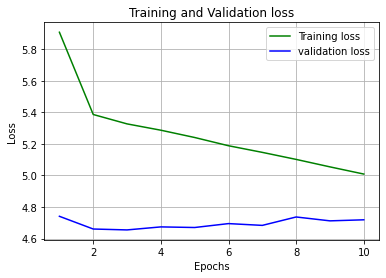

In [ ]:
#  training loss vs validation Accuracy
import matplotlib.pyplot as plt

epochs = range(1,11)
plt.plot(epochs, train_l, 'g', label='Training loss')
plt.plot(epochs, test_l, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [ ]:
#load weights and tokenizer

path='./tut1-model.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)